In [3]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from loader import load_news_data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from textblob import TextBlob

df = load_news_data('../data/raw_analyst_ratings.csv')
print(df.head())
print(df.columns)


Loading data from ../data/raw_analyst_ratings.csv...
                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-

In [4]:
import sys
print("Current Python Executable:", sys.executable)

Current Python Executable: c:\Users\Abenezer\Desktop\KAIM Project\nova-financial-analytics-week1\venv2\Scripts\python.exe


In [5]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB
None
(1407328, 5)


In [6]:
print(type(df['headline']))
print(df['headline'].head())

<class 'pandas.core.series.Series'>
0              Stocks That Hit 52-Week Highs On Friday
1           Stocks That Hit 52-Week Highs On Wednesday
2                        71 Biggest Movers From Friday
3         46 Stocks Moving In Friday's Mid-Day Session
4    B of A Securities Maintains Neutral on Agilent...
Name: headline, dtype: object


In [7]:
# --- 1. Handling Null Values ---

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(df.isnull().sum())

# We focus on the 'headline' column since it's used for sentiment analysis.
# Strategy: Drop rows where the 'headline' is null, as we can't analyze empty text.
df.dropna(subset=['headline'], inplace=True)

print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null headlines: {df.shape[0]}")


--- 1. Null Value Check (Before Cleaning) ---
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64

--- Null Value Check (After Cleaning) ---
Remaining rows after dropping null headlines: 1407328


In [8]:
# --- 3. Duplicate and Consistency Checks ---

# Check for duplicate rows across all columns
duplicate_count = df.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    df.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {df.shape[0]}")

# Ensure the 'headline' column is string type before analysis
df['headline'] = df['headline'].astype(str)


Total duplicate rows found: 1
Rows remaining after dropping duplicates: 1407327


In [9]:
# --- 2. Date Structure and Time Series Preparation  ---

if 'date' in df.columns:
    
    # 1. Force conversion using 'ISO8601' format and ensure UTC conversion.
    # Setting utc=True handles the mixed timezone offsets by normalizing all values to UTC 
    # and ensures the resulting column is a proper datetime dtype.
    df['date'] = pd.to_datetime(df['date'], format='ISO8601', utc=True)
    
    print("\n--- 2. Date Column Structure (After Conversion) ---")
    print(df['date'].head())
    print(f"Data type is now: {df['date'].dtype}")

    # 2. Set the Index
    # Note: Since utc=True was used, the dates are already in UTC.
    df.set_index('date', inplace=True)
    print("\nDataFrame Index is now set to Date (UTC).")
    print(df.head()) 
    
else:
    print("\nWarning: Date column not found. Skipping date conversion.")


--- 2. Date Column Structure (After Conversion) ---
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]

DataFrame Index is now set to Date (UTC).
                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   

                                                                         url  \
date                                


Headline Length Stats:
count    1.407327e+06
mean     7.312054e+01
std      4.073532e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


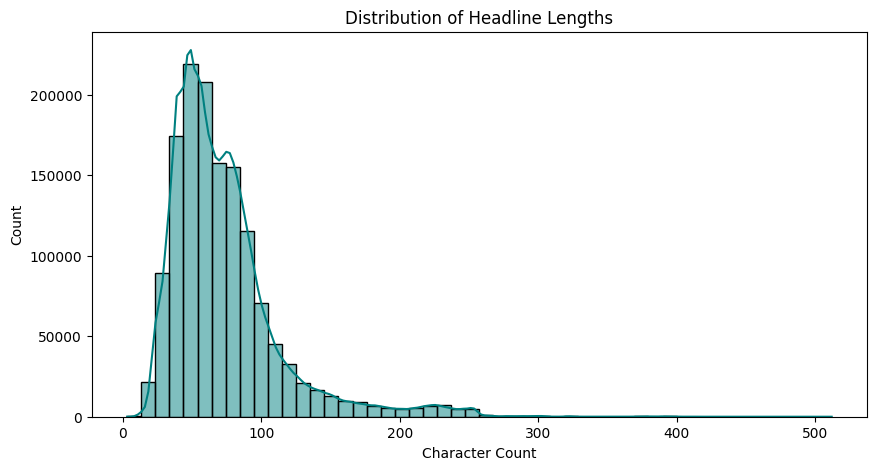


Total unique publishers: 1034
Top 5 Active Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64


C:\Users\Abenezer\AppData\Local\Temp\ipykernel_41572\333780484.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.head(10).values, y=publisher_counts.head(10).index, palette='viridis')


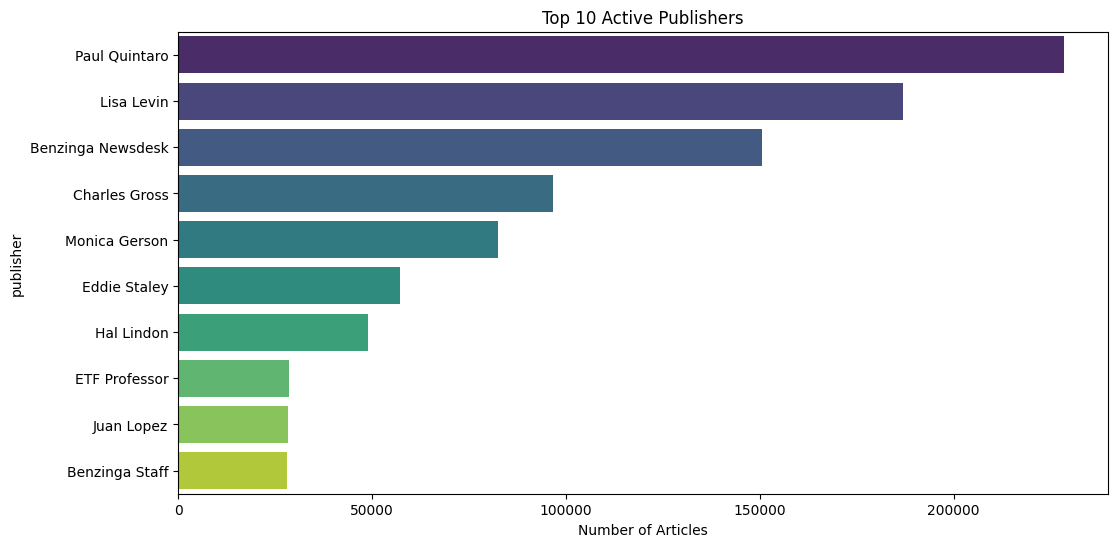

In [10]:
df['headline_length'] = df['headline'].astype(str).apply(len)
print("\nHeadline Length Stats:")
print(df['headline_length'].describe())

# Plot Headline Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=50, kde=True, color='teal')
plt.title('Distribution of Headline Lengths')
plt.xlabel('Character Count')
plt.show()

# B. Articles per Publisher (Top 10)
publisher_counts = df['publisher'].value_counts()
print(f"\nTotal unique publishers: {len(publisher_counts)}")
print("Top 5 Active Publishers:")
print(publisher_counts.head(5))

# Plot Top 10 Publishers
plt.figure(figsize=(12, 6))
sns.barplot(x=publisher_counts.head(10).values, y=publisher_counts.head(10).index, palette='viridis')
plt.title('Top 10 Active Publishers')
plt.xlabel('Number of Articles')
plt.show()

In [11]:
sample = df.head(100)
print("\nSample Headlines for Text Vectorization:")
print(sample['headline'].head())


Sample Headlines for Text Vectorization:
date
2020-06-05 14:30:54+00:00              Stocks That Hit 52-Week Highs On Friday
2020-06-03 14:45:20+00:00           Stocks That Hit 52-Week Highs On Wednesday
2020-05-26 08:30:07+00:00                        71 Biggest Movers From Friday
2020-05-22 16:45:06+00:00         46 Stocks Moving In Friday's Mid-Day Session
2020-05-22 15:38:59+00:00    B of A Securities Maintains Neutral on Agilent...
Name: headline, dtype: object


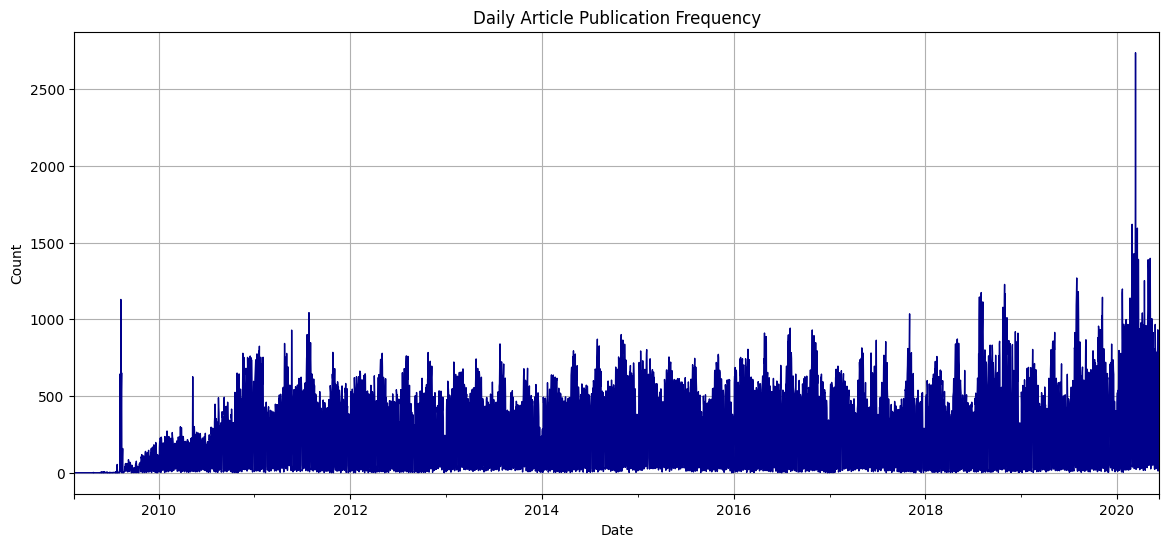

C:\Users\Abenezer\AppData\Local\Temp\ipykernel_41572\3412358897.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='coolwarm')


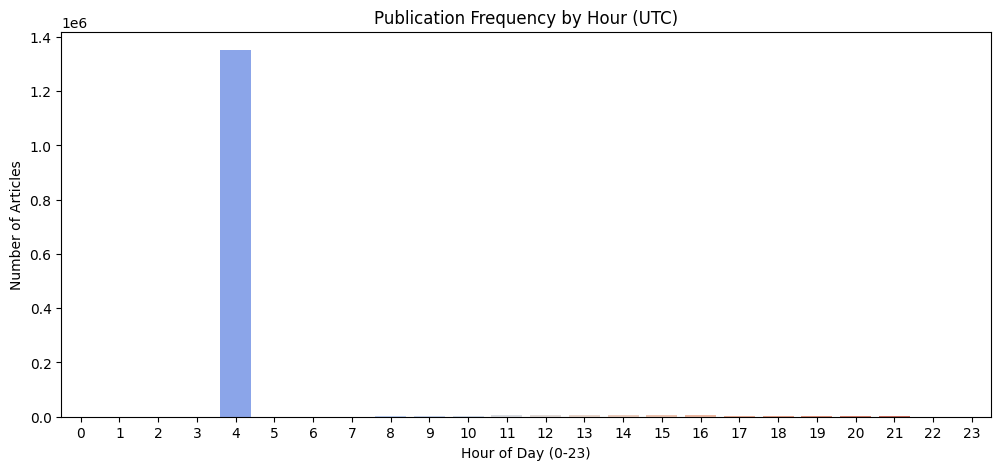

In [12]:
daily_counts = df.resample('D').size()

plt.figure(figsize=(14, 6))
daily_counts.plot(color='darkblue', linewidth=1)
plt.title('Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# ==========================================
# B. Analysis of Publishing Times (Hour of Day)
# ==========================================
# Access the hour directly from the index
df['hour'] = df.index.hour

plt.figure(figsize=(12, 5))
sns.countplot(x='hour', data=df, palette='coolwarm')
plt.title('Publication Frequency by Hour (UTC)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Articles')
plt.show()

            Term  Frequency
0        52 week      51006
1   price target      47274
2  stocks moving      40044
3        mid day      37324
4  market update      33101


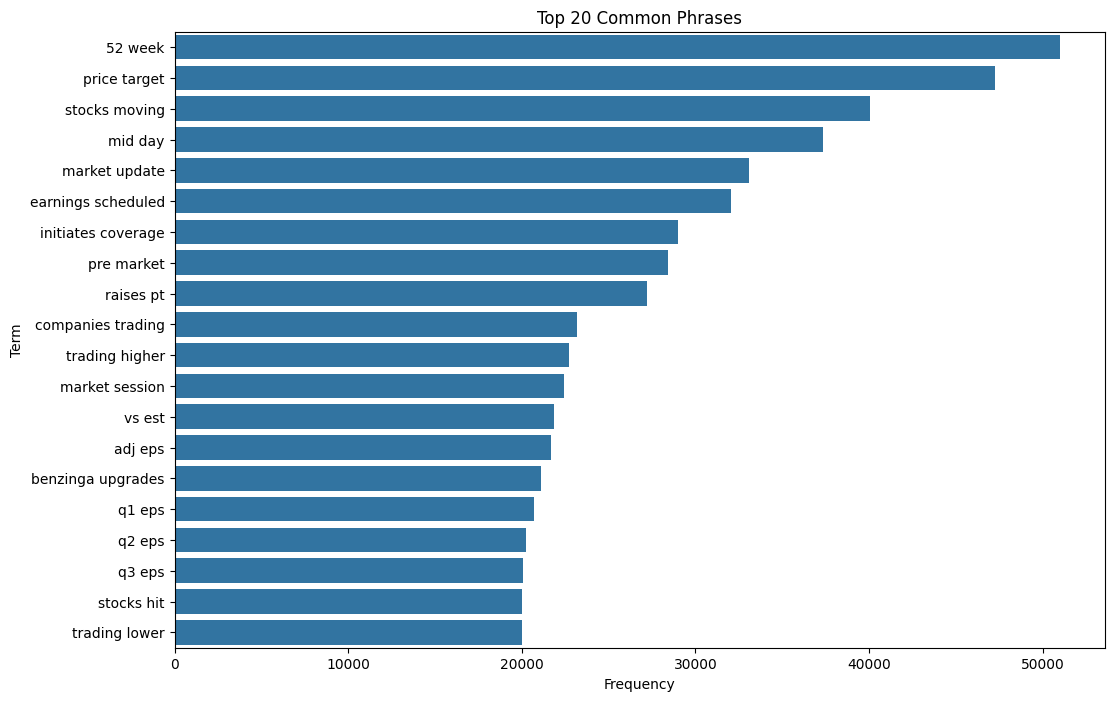

In [13]:
def get_top_n_words(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

common_bigrams = get_top_n_words(df['headline'].dropna(), 20, ngram_range=(2, 2))
df_bigram = pd.DataFrame(common_bigrams, columns=['Term', 'Frequency'])
print(df_bigram.head())

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Term', data=df_bigram)
plt.title('Top 20 Common Phrases')
plt.show()


publisher_domain
benzinga.com      7937
gmail.com          139
andyswan.com         5
investdiva.com       2
tothetick.com        2
Name: count, dtype: int64


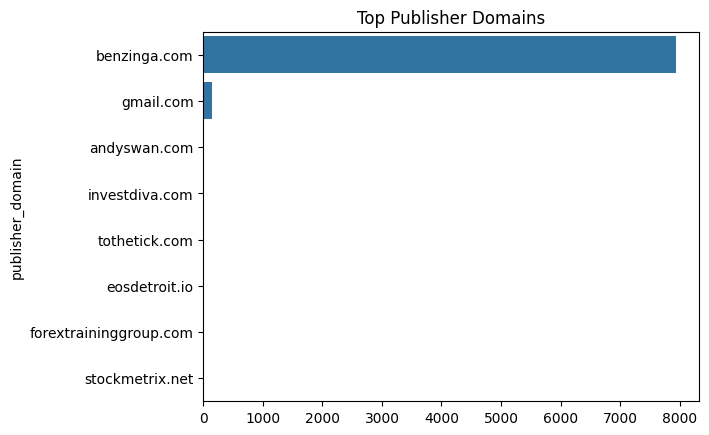


Analysis Complete.


In [14]:
def extract_domain(publisher):
    if isinstance(publisher, str) and '@' in publisher:
        return publisher.split('@')[-1]
    return np.nan

df['publisher_domain'] = df['publisher'].apply(extract_domain)
domain_counts = df['publisher_domain'].value_counts()
print(domain_counts.head())

sns.barplot(x=domain_counts.head(10).values, y=domain_counts.head(10).index)
plt.title('Top Publisher Domains')
plt.show()

print("\nAnalysis Complete.")

In [15]:
sample = df.head(100)

In [16]:
sample['TextBlob_Sentiment'] = sample['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)
print(sample[['headline','TextBlob_Sentiment','TextBlob_Category']])


                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   
...                                                                      ...   
2019-10-09 04:00:00+00:00  Barclays Maintains Equal-Weight on Agilent Tec...   
2019-10-08 04:00:00+00:00  Shares of several healthcare companies are tra...   
2019-10-02 04:00:00+00:00  Shares of several healthcare companies are tra...   
2019-09-05 04:00:00+00:00  Shares of several healthcare companies are tra...   
2019-09-03 04:00:00+00:00  Agilent Colla

C:\Users\Abenezer\AppData\Local\Temp\ipykernel_41572\3901196267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['TextBlob_Sentiment'] = sample['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\Abenezer\AppData\Local\Temp\ipykernel_41572\3901196267.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)
